In [1114]:
import pandas as pd 
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer

### LIMPIEZA DE DATOS

##### TAMAÑO DEL DF

In [1115]:
path='c:/Users/afonseca/Desktop/data_market.csv'
df=pd.read_csv(path,encoding='ISO-8859-1',delimiter=';',index_col='Row ID')

##### TAMAÑO DEL DF

In [1116]:
print(f'el tamaño del dataframe es de {df.shape[0]} filas y {df.shape[1]} columnas')

el tamaño del dataframe es de 9994 filas y 20 columnas


##### TIPO COLUMNAS

In [1117]:
columnas_numericas=df.select_dtypes(include=['number']).columns
columnas_categoricas=df.select_dtypes(include=['object']).columns
print(f'la cantidad de columnas numericas es {len(columnas_numericas)} y la de categoricas es {len(columnas_categoricas)}')

la cantidad de columnas numericas es 3 y la de categoricas es 17


##### CAMBIAR TIPO STRING A FLOAT

In [1118]:
def remplazos(df):
    df['Profit'] = df['Profit'].str.replace('.','')
    df['Profit'] = df['Profit'].astype('Float64')
    df['Sales'] = df['Sales'].str.replace('.','')
    df['Sales'] = df['Sales'].astype('Float64')
    
    return df
    

In [1119]:
df=remplazos(df)

##### VALORES NULLOS 

In [1120]:
nullos=df.isnull().sum().reset_index()
nullos=nullos.rename(columns={'index':'columnas',0:'nullos_c'})
nullos=nullos[nullos.nullos_c>0]
nullos=nullos.set_index('columnas')
print(f'el numero de columnas con datos nullos es de {nullos.shape[0]}\
 para un total de {np.array(nullos.nullos_c).sum()} datos nullos en todo el data set')
nullos


el numero de columnas con datos nullos es de 4 para un total de 24 datos nullos en todo el data set


,nullos_c
columnas,
Sales,6
Quantity,6
Discount,6
Profit,6


##### FILTRAR VALORES NULLOS EN DF 

In [1121]:
filtered_df = df[df.isna().any(axis=1)]

##### % VALORES NULLOS 

In [1122]:
nullos['%']=round((nullos['nullos_c']/df.shape[0])*100,3)
nullos.loc['total'] = ['=',np.array(nullos['%']).sum()]
nullos

,nullos_c,%
columnas,,
Sales,6,0.06
Quantity,6,0.06
Discount,6,0.06
Profit,6,0.06
total,=,0.24


##### REMPLAZAR NULLOS POR PROMEDIO

In [1123]:
#df.replace(np.nan, 0,inplace=True)
# Reemplazar TSH por la media
mean_imputer = SimpleImputer(strategy='mean')
df.loc[:,['Sales','Quantity','Discount','Profit']] \
        = mean_imputer.fit_transform(df[['Sales','Quantity','Discount','Profit']])


In [1124]:
# SE VERIFICA QUE NO HAY VALORES NULLOS
df.isnull().values.any()

False

##### VALORES DUPLICADOS

In [1125]:
df.index.duplicated().sum()

0

##### SELECCION DE FEATURES Y AGREGAR FUNCIONES DE TIEMPO

In [1126]:
def tiempo(df):
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['año']=df['Ship Date'].dt.year
    df['mes']=df['Ship Date'].dt.month
    df['dia']=df['Ship Date'].dt.day
    return df

In [1127]:
# se borra pais por que solo tiene un solo country 
df__=df.loc[:,['Ship Date','Ship Mode','Customer Name','Segment','City','State','Category','Sub-Category','Quantity','Profit']]
df__=tiempo(df__)


##### VALORES UNICOS 

In [1128]:
def unicos(df):
    unicos={i:df[i].nunique()  for i in df.columns }
    return pd.DataFrame(unicos,index=['unicos'])\
            .T.sort_values(by='unicos',ascending=True)

In [1129]:
unicos_=unicos(df__)
unicos_

,unicos
Segment,3
Category,3
Ship Mode,4
año,5
mes,12
Quantity,15
Sub-Category,17
dia,31
State,49
City,531


Al examinar los valores únicos, se puede detectar la diversidad y la distribución de los datos en cada variable, lo que ayuda a comprender mejor las relaciones y patrones presentes

##### MEDIDAS ESTADISTICAS  PROFIT

In [1130]:
promedio_profit=round(np.array(df__['Profit']).mean(),0)
max_profit=round(np.array(df__['Profit']).max(),0)
min_profit=round(np.array(df__['Profit']).min(),0)
desv_=round(np.array(df__['Profit']).std(),0)
Q1=np.percentile(np.array(df__['Profit']),25)
Q3=np.percentile(np.array(df__['Profit']),75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

##### RESUMEN ESTADISTICO

In [1131]:
resumen={
    'promedio_profit':promedio_profit,
    'max_profit':max_profit,
    'min_profit':min_profit,
    'desv_':desv_,
    'Q1':Q1,
    'Q3':Q3,
    'limite_inferior':limite_inferior,
    'limite_superior':limite_superior
}
resumen=pd.DataFrame(resumen,index=['resumen'])
resumen

,promedio_profit,max_profit,min_profit,desv_,Q1,Q3,limite_inferior,limite_superior
resumen,179906.0,67199808.0,-38399904.0,1722850.0,2245.0,151083.0,-221012.0,374340.0


##### AGRUPAR DATOS
#### segmento

##### conteo por segmento

In [1132]:
# segmento por cliente
segmento=df__.groupby(['Segment'])['Segment'].count()
segmento=segmento.reset_index(name='conteo')


##### pivot por segmentos y año

In [1133]:
tabla_pivote = pd.pivot_table(
    df__, 
    values='Profit',        
    index='año',            
    columns='Segment',      
    aggfunc='sum',          
    fill_value=0            
)

#### ciudad y estado

##### conteo por ciudad y suma de profit

In [1134]:
ciudad=df__.groupby(['City'])['Profit'].sum()
ciudad=ciudad.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
ciudad['valores'] = ciudad['sum'].apply(lambda x: '{:,.0f}'.format(x))
conteo=df__.groupby(['City'])['City'].count()
conteo=conteo.reset_index(name='conteo')
df_result=pd.merge(ciudad,conteo,on='City')
df_result=df_result.iloc[:,[0,2,3]]


##### profit estado

In [1135]:
estado=df__.groupby(['State'])['Profit'].sum()
estado=estado.reset_index(name='sum').sort_values(by='sum',ascending=False).head(21)
estado['valores'] = estado['sum'].apply(lambda x: '{:,.0f}'.format(x))
estado=estado.iloc[:,[0,2]]


#### categoricas

##### categorias mas frecuentes

In [1136]:
categoria=df__.groupby('Category')['Category'].count()
categoria=categoria.reset_index(name='conteo')
categoria_s=df__.groupby('Category')['Profit'].sum()
categoria_s=categoria_s.reset_index(name='suma')
categoria_s['valores'] = categoria_s['suma'].apply(lambda x: '{:,.0f}'.format(x))
categoria_s=pd.merge(categoria,categoria_s,on='Category').sort_values(by='suma',ascending=False)
categoria_s

,Category,conteo,suma,valores
2,Technology,1847,962768840.8336,"962,768,841"
1,Office Supplies,6026,775994074.0,"775,994,074"
0,Furniture,2121,59222369.0,"59,222,369"


In [1137]:
tabla_pivote_categoria = pd.pivot_table(
    df__, 
    values='Profit',        
    index='año',            
    columns='Category',      
    aggfunc='sum',          
    fill_value=0            
)

##### pedidos a lo largo del tiempo

In [1138]:
años_=df__.groupby('año')['año'].count()
años_=años_.reset_index(name='conteo')
años_profit=df__.groupby('año')['Profit'].sum()
años_profit=años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen=pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen=años_resumen.iloc[:,[0,1,3]]


##### Analisis Grafico

##### grafica  de tendencia de pedidos

¿ que tipo de tendencia tiene los pedidos en los ultimos años?

¿ Se experimentó una desaceleración en las ganancias?

In [1139]:
plt.style.use('seaborn-v0_8')

In [1140]:
años_=df__.groupby('año')['año'].count()
años_=años_.reset_index(name='conteo')
años_profit=df__.groupby('año')['Profit'].sum()
años_profit=años_profit.reset_index(name='suma')
años_profit['valores'] = años_profit['suma'].apply(lambda x: '{:,.0f}'.format(x))
años_resumen=pd.merge(años_,años_profit,on='año').sort_values(by='año',ascending=False)
años_resumen=años_resumen.iloc[:,[0,1,3]]

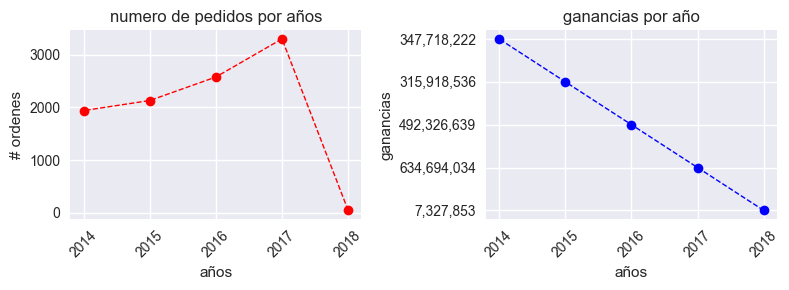

In [1141]:
fig,ax = plt.subplots(1,2, figsize=(8, 3))

ax[0].plot(años_resumen['año'],años_resumen['conteo'],color='red',marker='o',linestyle='--',linewidth=1)
ax[1].plot(años_resumen['año'],años_resumen['valores'],color='b',marker='o',linestyle='--',linewidth=1)

ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel('años')
ax[0].set_ylabel('# ordenes')
ax[0].set_title('numero de pedidos por años')

ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('años')
ax[1].set_ylabel('ganancias')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('ganancias por año')

plt.tight_layout()
plt.show()



##### grafica  de ganancias por segmento 

¿Existen diferencias significativas en el comportamiento de las ganancias entre los tres segmentos?

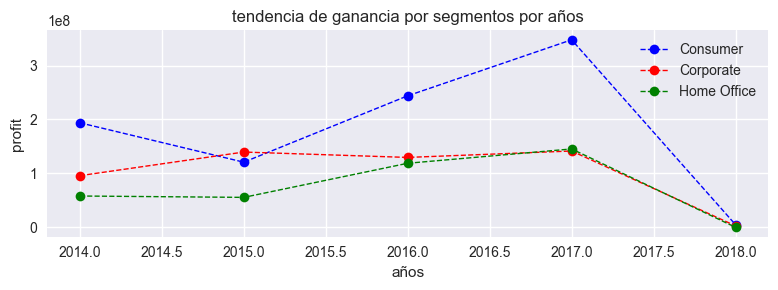

In [1142]:
fig , ax =plt.subplots(figsize=(8, 3))

ax.plot(tabla_pivote.index,tabla_pivote['Consumer'],color='b',marker='o',linestyle='--',linewidth=1,label='Consumer')
ax.plot(tabla_pivote.index,tabla_pivote['Corporate'],color='r',marker='o',linestyle='--',linewidth=1,label='Corporate')
ax.plot(tabla_pivote.index,tabla_pivote['Home Office'],color='g',marker='o',linestyle='--',linewidth=1,label='Home Office')
ax.set_title('tendencia de ganancia por segmentos por años')
ax.set_ylabel('profit')
ax.set_xlabel('años')

ax.legend()

plt.tight_layout()
plt.show()

##### grafica  de conteo de ordenes y ganancia por categoria y años

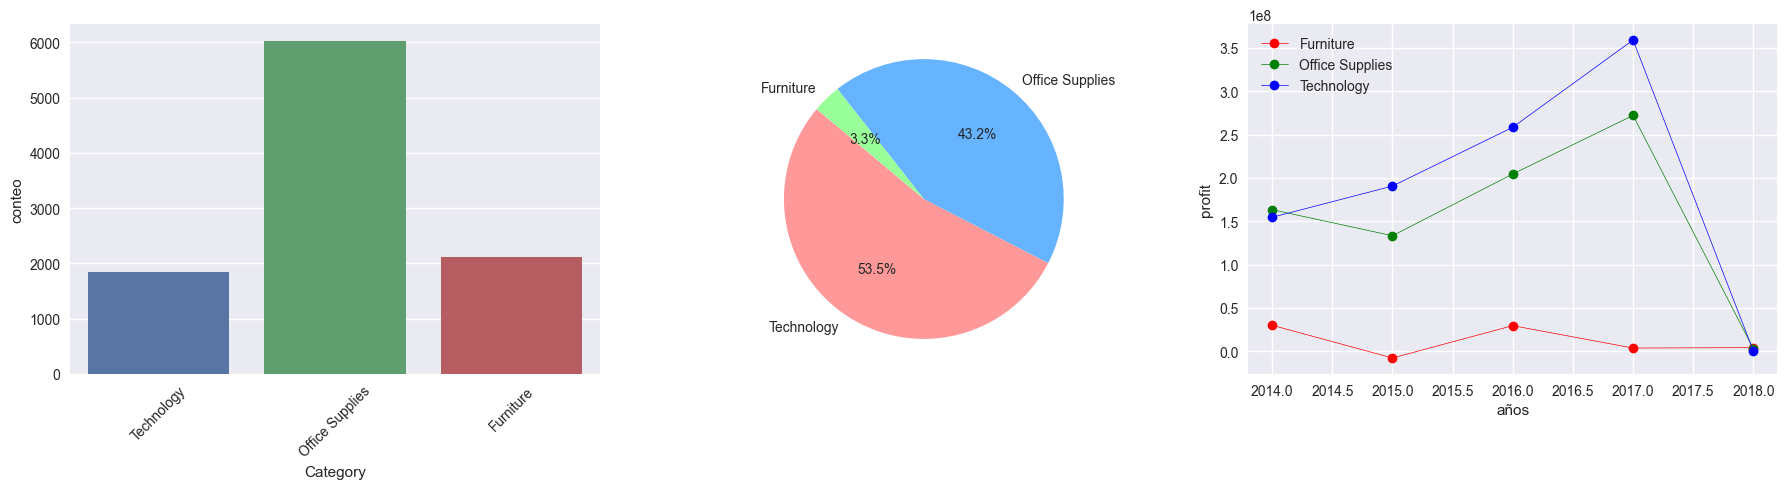

In [1145]:
fig , ax =plt.subplots(1,3,figsize=(18, 5))

sns.barplot(x=categoria_s.Category,y=categoria_s.conteo,data=categoria_s,hue='Category',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)

ax[2].set_xlabel('años')
ax[2].set_ylabel('profit')

ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Furniture'],color='r',marker='o',linestyle='-',linewidth=0.5,label='Furniture')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Office Supplies'],color='g',marker='o',linestyle='-',linewidth=0.5,label='Office Supplies')
ax[2].plot(tabla_pivote_categoria.index,tabla_pivote_categoria['Technology'],color='b',marker='o',linestyle='-',linewidth=0.5,label='Technology')
ax[2].legend()

ax[1].pie(categoria_s['suma'], labels=categoria_s['Category'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

plt.tight_layout()

plt.show()